<h1 style="font-size: 200%;color: darkgreen; font-weight: bold; text-align:center">Numerical Simulation Laboratory 2021</h1>

<p style="text-align:center"><b>Author:</b> Giacomo Riccardo Hvaring</p>

---
    

# 11.  Neural Network Regression with Keras
    

## the prediction problem

Consider a probabilistic process that gives rise to labeled data $(x,y)$, for example by drawing samples from the equation

$$
    y_i= f(x_i) + \eta_i,
$$

where $f(x_i)$ is some fixed (possibly unknown) function, and $\eta_i$ is a Gaussian, uncorrelated noise variable such that

$$
\langle \eta_i \rangle=0 \\
\langle \eta_i \eta_j \rangle = \sigma\;\delta_{ij}
$$

We will refer to the $f(x_i)$ as the **true features** used to generate the data. 

To make predictions, we will consider a neural network (NN) that dependent on some weights and biases. The functions that the NN can model respresent the **model class** that we are using to try to model the data and make predictions.

To have the NN learn the best parameters for fitting the data, we will train our models on a **training data set** and then test the effectiveness of the NN on a *different* dataset, the **validation data set**. The reason we must divide our data into a training and test dataset is that the point of machine learning is to make accurate predictions about new data we have not seen.

To measure our ability to predict, we will make the NN learn the best parameter it can by fitting the training data and then make predictions using data from the test data set. One common measure of predictive  performance of our algorithm is to compare the predictions, $\{y_j^\mathrm{pred}\}$, to the true values $\{y_j\}$ by evaluating some cost function, a commonly employed measure for this is the sum of the mean square-error (MSE) on the test set:
$$
MSE= \frac{1}{N_\mathrm{test}}\sum_{j=1}^{N_\mathrm{test}} (y_j^\mathrm{pred}-y_j)^2
$$

We will try to get a qualitative picture by examining plots on validation and training data.

In [1]:
from libsim import *                        # module containing some handy functions for the labs

results_directory += "lab_11/"              # where to look for the data
HTML(custom_css())   

## exercise 11.1

We start by considering the very simple case:

$$
f(x)=2x+1
$$

after defining the parameters of an ideal linear function, we then try to predict them using a neural network regression

<p class="assignement"> Explore how the linear regression depends on the number of epochs, $N_{\rm epochs}$, the number of data points $N_{\rm train}$ and on the noise $\sigma$. Try to improve the result operating on these parameters.</p>

<p class="remark"> The best NN is the one that uses LESS resources to produce the BEST results (try to match the complexity of the network with the one of the problem it's going to solve).</p>

In [2]:
# compose the NN model
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

In [3]:
# curve parameters
m = 2
b = 1

def training_inputs(ntrain, sigma=0, fraction_for_testing=0.1):
    np.random.seed(0) # for repeatability
    # training data
    x_train = np.random.uniform(-1, 1, ntrain)
    y_train = np.random.normal(m * x_train + b, sigma)
    # validation data
    x_test = np.random.uniform(-1, 1, int(ntrain * fraction_for_testing))
    x_test.sort()
    y_test = np.random.normal(m * x_test + b, sigma)
    return x_train, y_train, x_test, y_test


def plot_linear_train(sigma=0, ntrain=500, nepochs=30, batch_size=32):
    # plot training and target dataset

    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    sigma_label = f'$\sigma={sigma:.2f}$' if sigma > 0 else f'$\sigma={int(sigma)}$'

    x_train, y_train, x_test, y_test = training_inputs(ntrain, sigma=sigma)
    y_target = m * x_test + b

    # create model
    model = tf.keras.Sequential()
    model.add(Dense(1, input_shape=(1,)))
    # compile the model choosing optimizer, loss and metrics objects
    model.compile(optimizer='sgd', loss='mse', metrics=['mse'])
    # fit the model using training dataset
    history = model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=nepochs,
                        shuffle=True, # a good idea is to shuffle input before at each epoch
                        validation_data=(x_test, y_test), verbose=False);
    # evaluate model
    print('Model evaluation with validation data\n')
    score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=True)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    # evaluate model with the exact curve
    print('\nModel evaluation with target data (different only when sigma != 0)\n')
    score = model.evaluate(x_test, y_target, batch_size=batch_size, verbose=True)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print(score)
    
    # plot comparison
    set_labels(ax[0], "datasets with " + sigma_label, "x", "y")
    ax[0].plot(x_test, y_target, label='target', lw=2, c='k', zorder=1)
    ax[0].scatter(x_test, y_test, color='darkgrey', s=20, marker='x', label='validation', zorder=2)
    x_predicted = np.random.uniform(-1, 1, 100)
    y_predicted = model.predict(x_predicted)
    ax[0].scatter(x_predicted, y_predicted, color='darkgreen', marker='.', s=40, label='predicted', zorder=3);
    
    # plot training & validation loss values
    ax[1].plot(history.history['loss'], label='training')
    ax[1].plot(history.history['val_loss'], label='test')
    set_labels(ax[1], 'model loss', 'epoch', 'loss')
    ax[1].legend();
    ax[0].legend();

Model evaluation with validation data

4/4 [==============================] - 0s 1ms/step - loss: 0.2087 - mse: 0.2087
Test loss: 0.20870308578014374
Test accuracy: 0.20870308578014374

Model evaluation with target data (different only when sigma != 0)

4/4 [==============================] - 0s 1ms/step - loss: 2.7604e-04 - mse: 2.7604e-04
Test loss: 0.0002760385104920715
Test accuracy: 0.0002760385104920715
[0.0002760385104920715, 0.0002760385104920715]


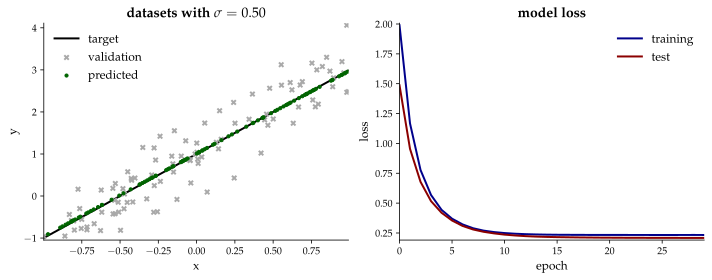

In [4]:
plot_linear_train(sigma=0.5, ntrain=1000, nepochs=30, batch_size=32)

Generally speaking, increasing the number of data points in the training set and the epochs improves the quality of the fit.

## exercise 11.2

Extend the model to obtain a reasonable fit of the following polynomial of order 3:

$$
f(x)=4-3x-2x^2+3x^3
$$
for $x \in [-1,1]$.

In order to make practice with NN, explore reasonable different choices for:

- the number of layers
- the number of neurons in each layer
- the activation function
- the optimizer
- the loss function
  
Make graphs comparing fits for different NNs.
Check your NN models by seeing how well your fits predict newly generated test data (including on data outside the range you fit. How well do your NN do on points in the range of $x$ where you trained the model? How about points outside the original training data set? 
Summarize what you have learned about the relationship between model complexity (number of parameters), goodness of fit on training data, and the ability to predict well.

In [5]:
# curve parameters
c = [4, -3, -2, 3]

def f(x):
    return np.sum([ c[i] * x**i for i in range(len(c)) ], axis=0)

ntrain = 1000
nepochs = 30
batch_size = 32
sigma = 0

def training_inputs_nlin(ntrain, fraction_for_testing=0.2):
    np.random.seed(0) # for repeatability
    # training data
    x_train = np.random.uniform(-1, 1, ntrain)
    y_train = np.random.normal(f(x_train), sigma)
    # validation data
    x_test = np.random.uniform(-1, 1, int(ntrain * fraction_for_testing))
    x_test.sort()
    y_test = np.random.normal(f(x_test), sigma)
    return x_train, y_train, x_test, y_test


def train_nonlinear_f(nlayers=2, neurons_per_layer=5, optimizer='sgd', loss='mse', activation='relu'):
    x_train, y_train, x_test, y_test = training_inputs_nlin(ntrain)
    y_target = f(x_test)
    
    # create model
    model = tf.keras.Sequential()
    model.add(Dense(neurons_per_layer, input_shape=(1,), activation=activation))
    for layer in range(1, nlayers - 2):
        model.add(Dense(neurons_per_layer, activation=activation))
    model.add(Dense(1))
    # compile the model choosing optimizer, loss and metrics objects
    model.compile(optimizer=optimizer, loss=loss, metrics=['mse'])
    
    # get a summary of our composed model
    #model.summary()
    
    # fit the model using training dataset
    history = model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=nepochs,
                        shuffle=True, # a good idea is to shuffle input before at each epoch
                        validation_data=(x_test, y_test), verbose=False);
    
    print('\nInternal layers: ', nlayers - 2)
    print('Neurons per layer: ', neurons_per_layer)
    
    dataset = x_test, y_test, y_target
    
    return dataset, model, history
    
def plot_comparison(ax, dataset, model, history):
    x_test, y_test, y_target = dataset
    set_labels(ax[0], "datasets", "x", "y")
    x = np.random.uniform(-1.5, 1.5, 100)
    x.sort()
    ax[0].plot(x, f(x), label='target', lw=2, c='k', zorder=1)
    to_plot = np.random.randint(0, x_test.size, 100)
    ax[0].scatter(x_test[to_plot], y_test[to_plot], color='darkgrey', s=20, marker='x', label='validation', zorder=2)
    x_predicted = np.random.uniform(-1.5, 1.5, 100)
    y_predicted = model.predict(x_predicted)
    ax[0].scatter(x_predicted, y_predicted, color='darkgreen', marker='.', s=40, label='predicted', zorder=3);
    
    # plot training & validation loss values
    ax[1].plot(history.history['loss'], label='training')
    ax[1].plot(history.history['val_loss'], label='test')
    set_labels(ax[1], 'model loss', 'epoch', 'loss')
    ax[1].legend();
    ax[0].legend();


Internal layers:  4
Neurons per layer:  8


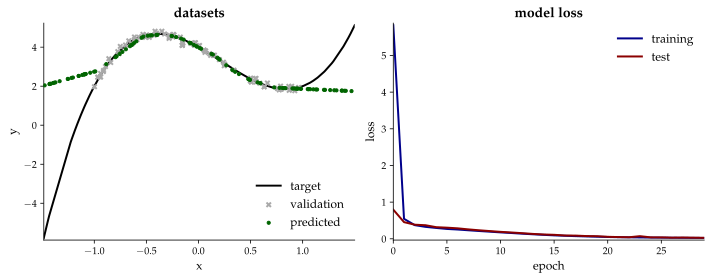

In [6]:
ntrain = 1000
nepochs = 30
batch_size = 32
sigma = 0.1

dataset, model, history = train_nonlinear_f(nlayers=6, neurons_per_layer=8, optimizer='sgd', loss='mse')

fig, ax = plt.subplots(1, 2, figsize=(10,4))
plot_comparison(ax, dataset, model, history)


Internal layers:  4
Neurons per layer:  10


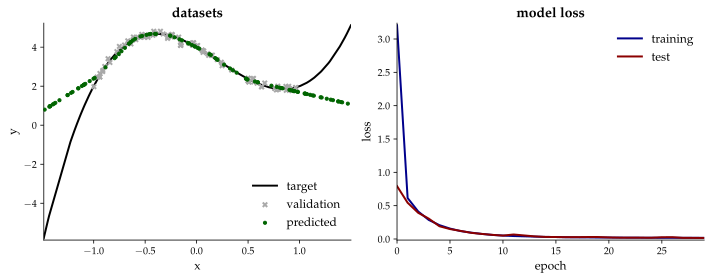

In [7]:
ntrain = 1000
nepochs = 30
batch_size = 32
sigma = 0.1

dataset, model, history = train_nonlinear_f(nlayers=6, neurons_per_layer=10, optimizer='sgd', loss='mse')

fig, ax = plt.subplots(1, 2, figsize=(10,4))
plot_comparison(ax, dataset, model, history)


Internal layers:  4
Neurons per layer:  20


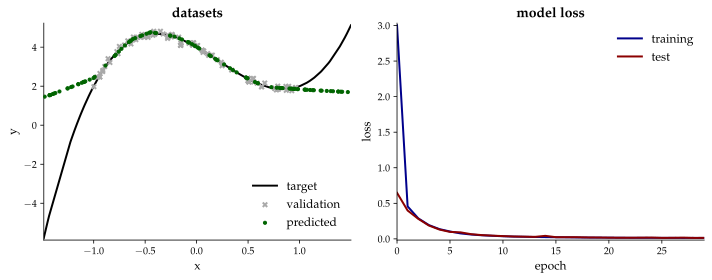

In [8]:
ntrain = 1000
nepochs = 30
batch_size = 32
sigma = 0.1

dataset, model, history = train_nonlinear_f(nlayers=6, neurons_per_layer=20, optimizer='sgd', loss='mse')

fig, ax = plt.subplots(1, 2, figsize=(10,4))
plot_comparison(ax, dataset, model, history)


Internal layers:  6
Neurons per layer:  10


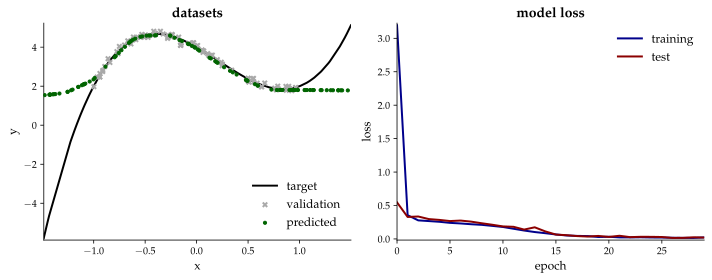

In [9]:
ntrain = 1000
nepochs = 30
batch_size = 32
sigma = 0.1

dataset, model, history = train_nonlinear_f(nlayers=8, neurons_per_layer=10, optimizer='sgd', loss='mse')

fig, ax = plt.subplots(1, 2, figsize=(10,4))
plot_comparison(ax, dataset, model, history)


Internal layers:  4
Neurons per layer:  10

Internal layers:  4
Neurons per layer:  10


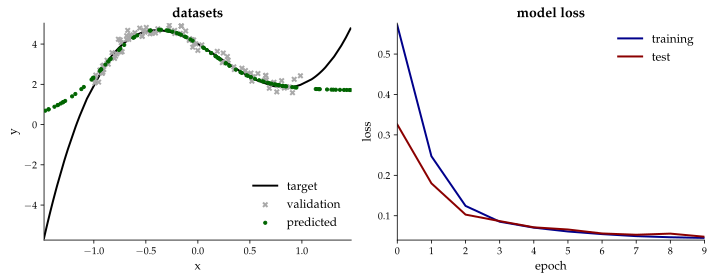

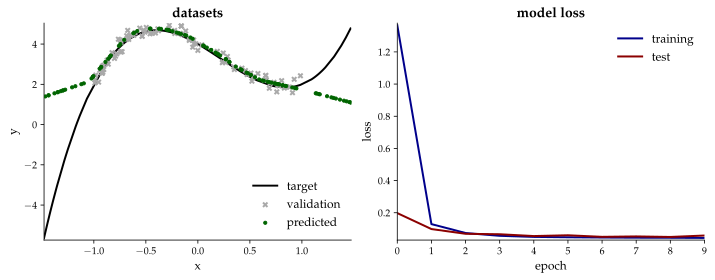

In [10]:
ntrain = 5000
nepochs = 10
batch_size = 32
sigma = 0.2

dataset, model, history = train_nonlinear_f(nlayers=6, neurons_per_layer=10, optimizer='sgd', loss='mse', 
                                            activation='tanh')

fig, ax = plt.subplots(1, 2, figsize=(10,4))
plot_comparison(ax, dataset, model, history)

dataset, model, history = train_nonlinear_f(nlayers=6, neurons_per_layer=10, optimizer='sgd', loss='mse', 
                                            activation='relu')

fig, ax = plt.subplots(1, 2, figsize=(10,4))
plot_comparison(ax, dataset, model, history)

I started with 6 total layer to associate (at least in principle) one internal layer to each parameter of the polynomial. 

It turns out that with 1000 training points, a NN with 4 internal layers with 5 neurons each is not sufficient for approximating the polynomial, with particular problems at the limits of the domain. By increasing the number of neurons per layer the result gets slightly better.

The problem is that by only tweaking the number of layers/neurons per layer the NN is not able to guess points _outside_ the domain where it was trained.

<p class='remark'>It seems that when the NN is asked to extend the fit outside of the domain where it was trained, it follows approximately the shape of the activation function used for its neurons.</p>

## exercise 11.3
  
Try to extend the model to fit a simple trigonometric 2D function such as 

$$f(x,y) = \sin(x^2+y^2)$$ 

in the range $x \in [-3/2,3/2]$ and $y \in [-3/2,3/2]$.

In [11]:
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec

def s(x):
    x, y = x[:,0], x[:,1]
    return np.sin(x**2 + y**2)

def training_inputs_2d(ntrain, fraction_for_testing=0.1):
    np.random.seed(0) # for repeatability
    # training data
    x_train = np.array([ [np.random.uniform(-1.5, 1.5), np.random.uniform(-1.5, 1.5)] for i in range(ntrain) ])
    y_train = np.random.normal(s(x_train), sigma)
    # validation data
    x_test = np.array([ [np.random.uniform(-1.5, 1.5), np.random.uniform(-1.5, 1.5)] for i in range(ntrain) ])
    y_test = np.random.normal(s(x_test), sigma)
    return x_train, y_train, x_test, y_test

def train_2d_f(nlayers=2, neurons_per_layer=5, optimizer='sgd', loss='mse', activation='relu'):
    x_train, y_train, x_test, y_test = training_inputs_2d(ntrain)
    y_target = s(x_test)
    
    # create model
    model = tf.keras.Sequential()
    model.add(Dense(neurons_per_layer, input_shape=(2,), activation=activation))
    for layer in range(1, nlayers - 1):
        model.add(Dense(neurons_per_layer, activation=activation))
    model.add(Dense(1))
    # compile the model choosing optimizer, loss and metrics objects
    model.compile(optimizer=optimizer, loss=loss, metrics=['mse'])
    
    # get a summary of our composed model
    #model.summary()
    
    # fit the model using training dataset
    history = model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=nepochs,
                        shuffle=True, # a good idea is to shuffle input before at each epoch
                        validation_data=(x_test, y_test), verbose=False);
    
    print('\nInternal layers: ', nlayers - 2)
    print('Neurons per layer: ', neurons_per_layer)
    
    dataset = x_test, y_test, y_target
    
    return dataset, model, history

def settings_3d(ax):
    ax.view_init(5, 45)
    ax.set_frame_on(False)
    ax.grid(False)

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    
def plot_comparison_sin(fig, dataset, model, history):
    x_test, y_test, y_target = dataset
    x, y = np.random.uniform(-2, 2, 100), np.random.uniform(-2, 2, 100)
    X, Y = np.meshgrid(np.sort(x), np.sort(y))
    Z = np.sin(X**2 + Y**2)
    
    # plot target vs. prediction data
    gs = GridSpec(5, 5)
    ax0 = fig.add_subplot(gs[:,0:-2], projection='3d')
    ax0.plot_surface(X, Y, Z, color='k', alpha=0.1, zorder=1, label='target')
    ax0.set_title('datasets')
    settings_3d(ax0)
    ax0.view_init(30,-150)
    x_predict = np.array([ [np.random.uniform(-2, 2), np.random.uniform(-2, 2)] for i in range(500) ])
    x_in = x_predict[np.abs(x_predict[:,0]) < 1.5]
    x_in = x_in[np.abs(x_in[:,1]) < 1.5]
    x_out = x_predict[np.abs(x_predict[:,0]) >= 1.5]
    x_out = x_out[np.abs(x_out[:,1]) >= 1.5]
    y_in = model.predict(x_in)
    y_out = model.predict(x_out)
    ax0.scatter(x_in[:,0], x_in[:,1], y_in, color='darkgreen', label='predicted', alpha=.9)
    ax0.scatter(x_out[:,0], x_out[:,1], y_out, color='darkorange', label='predicted (outside)', alpha=.9)
    ax0.scatter(x_test[:100,0], x_test[:100,1], y_target[:100], marker='x', color='darkgrey', label='validation')
    
    # legend
    legend_elements = [Line2D([0], [0], lw=10, alpha=0.1, color='k', label='target'), 
                       Line2D([0], [0], lw=0, marker='o', color='darkgreen', label='predicted (inside)'),
                       Line2D([0], [0], lw=0, marker='o', color='darkorange', label='predicted (outside)'),
                       Line2D([0], [0], lw=0, marker='x', color='darkgrey', label='validation')]
    ax0.legend(handles=legend_elements, loc='upper left');
    
    # plot training & validation loss values
    ax1 = fig.add_subplot(gs[1:-1,-2:])
    ax1.plot(history.history['loss'], label='training')
    ax1.plot(history.history['val_loss'], label='test')
    set_labels(ax1, 'model loss', 'epoch', 'loss')
    ax1.legend();


Internal layers:  6
Neurons per layer:  10


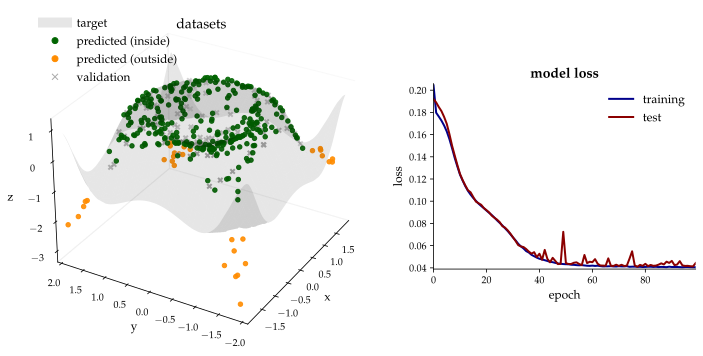

In [12]:
ntrain = 5000
nepochs = 100 # careful not to overfit the data!
batch_size = 32
sigma = 0.2

dataset, model, history = train_2d_f(nlayers=8, neurons_per_layer=10, optimizer='sgd', loss='mse')

fig = plt.figure(figsize=(10,5))
plot_comparison_sin(fig, dataset, model, history)

Very good in the training domain, not so much on the outside.

For an accurate prediction of points outside the "known" domain, some more sophisticate methods need to be employed apparently.